## initalise

In [1]:
## Initalise
from IPython.core.display import HTML
HTML("""
<style>
.container {
    width: 100%;
}
</style>
""")

In [2]:
import graphlab as gl
gl.canvas.set_target('ipynb')
import datetime
import os as os

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

2016-04-15 00:03:15,417 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.8.5 started. Logging: /tmp/graphlab_server_1460678593.log


This non-commercial license of GraphLab Create is assigned to kevin.mcisaac@gmail.com and will expire on November 06, 2016. For commercial licensing options, visit https://dato.com/buy/.


/home/ec2-user/anaconda2/envs/dato-env/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Load and format data
Load the online retail data and 
* Transform invoice date to datetime.datetime format
* Estimate the profit on the transaction as 10% of the revenue (i.e., Quantity * Unit Price). In a real example the data would either have this precalcualted or have sufficient columns to calculate this quantity.

In [3]:
if not os.path.exists('Data/online_retail'):
    sf = gl.SFrame('http://s3.amazonaws.com/dato-datasets/churn-prediction/online_retail.csv')
    sf['InvoiceDate']=sf['InvoiceDate'].str_to_datetime(str_format='%m/%d/%y %H:%M')
    sf['Profit'] = sf.apply(lambda row: row['Quantity']*row['UnitPrice']*0.15)
    sf.save('Data/online_retail')
else:
    sf = gl.SFrame('Data/online_retail')

In [4]:
print "Note: this data has\n* {} periods \n* {:4,d} unique customers\n* {:6,d} transactions".format(
    (sf['InvoiceDate'].max()-sf['InvoiceDate'].min()).days/datetime.timedelta(days = 30).days+1, len(sf['CustomerID'].unique()), len(sf))

Note: this data has
* 13 periods 
* 4,373 unique customers
* 541,909 transactions


# Customer Lifetime Value

This new method use a simple group aproach, rather than using TimeSeries and TimeSeriesGroup. This turns out to be about 100x faster and is much simpler to understand 

In [5]:
import CustomerLifetimeValue as CLV

## Computing CLV

In [6]:
churned, active = CLV.calculate(sf, 'InvoiceDate', 'CustomerID', 'Profit' )
churned

CustomerID,CLV,Lifetime
16257,7.0425,1
14406,23.5125,1
13518,98.916,1
16498,12.918,1
16820,74.6415,1
18126,31.0245,1
17325,14.52,1
16284,123.5955,1
17534,33.504,1
15062,148.179,10


In [7]:
active

CustomerID,Profit,Lifetime
13050,852.6915,12
14515,315.3135,7
17885,28.5285,1
13560,26.1555,1
15863,10.326,6
14388,475.806,13
16200,162.093,6
14897,204.957,10
17338,991.827,12
15615,1554.006,12


### Testing
Basic logical tests of CLV calculation

In [8]:
print 'Number of customers: Churned {} + Active {} == Total is {}'. format(len(churned), len(active), len(churned) + len(active) == len(sf['CustomerID'].unique()))

Number of customers: Churned 2677 + Active 1696 == Total is True


In [9]:
print 'Sum of profit: Churned (${:4,.2f})  + Active (${:4,.2f}) == Total (${:4,.2f}) is {}'.format( churned['CLV'].sum(), active['Profit'].sum(), sf['Profit'].sum(),
                                                                                                  abs(churned['CLV'].sum() + active['Profit'].sum() - sf['Profit'].sum()) < 1e-06)

Sum of profit: Churned ($346,938.72)  + Active ($1,115,223.47) == Total ($1,462,162.19) is True


### Ploting 

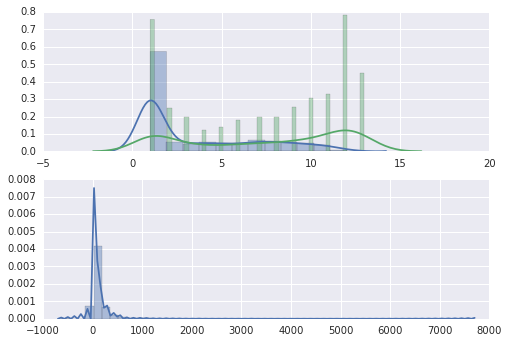

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1)
sns.distplot(churned['Lifetime'], bins=12, ax=ax1)
sns.distplot(active['Lifetime'], bins=50, ax=ax1)
sns.distplot(churned['CLV'], bins=50,  ax=ax2)

## Predictive modeling

In [11]:
sf['Period'] = CLV.period(sf, 'InvoiceDate', 'CustomerID')
sf.filter_by(13147, 'CustomerID').print_rows(50,max_row_width=200 )

+-----------+-----------+---------------+----------+---------------------+-----------+------------+----------------+--------+--------+
| InvoiceNo | StockCode |  Description  | Quantity |     InvoiceDate     | UnitPrice | CustomerID |    Country     | Profit | Period |
+-----------+-----------+---------------+----------+---------------------+-----------+------------+----------------+--------+--------+
|   565127  |   79321   | CHILLI LIGHTS |    24    | 2011-09-01 12:28:00 |    4.95   |   13147    | United Kingdom | 17.82  |   1    |
|   573129  |   79321   | CHILLI LIGHTS |    24    | 2011-10-27 16:35:00 |    4.95   |   13147    | United Kingdom | 17.82  |   2    |
|   575205  |   79321   | CHILLI LIGHTS |    48    | 2011-11-09 10:18:00 |    4.95   |   13147    | United Kingdom | 35.64  |   3    |
|   579451  |   79321   | CHILLI LIGHTS |    48    | 2011-11-29 13:59:00 |    4.95   |   13147    | United Kingdom | 35.64  |   3    |
+-----------+-----------+---------------+----------+---

In [12]:
train, test = CLV.features(sf, 'InvoiceDate', 'CustomerID', 'Profit')
train.print_rows(50,max_column_width=25, max_row_width=200 )
train, validate = train.random_split(0.8, seed=12345678)

+------------+--------------------------+--------------------------+--------------------------+----------+----------+--------------------------+-----+----------+
| CustomerID |        Purchases         |      Txs_by_period       |    Quantity_by_period    |   CLV    | Lifetime |     Profit_by_period     | Txs | Quantity |
+------------+--------------------------+--------------------------+--------------------------+----------+----------+--------------------------+-----+----------+
|   16257    |       [84629, C2]        |          {1: 2}          |          {1: 2}          |  7.0425  |    1     |       {1: 7.0425}        |  2  |    2     |
|   14406    | [21742, 22487, 23203,... |          {1: 8}          |         {1: 77}          | 23.5125  |    1     | {1: 23.512500000000003}  |  8  |    77    |
|   13518    | [22548, 23201, 22622,... |         {1: 38}          |         {1: 392}         |  98.916  |    1     |  {1: 98.91600000000001}  |  38 |   392    |
|   16498    | [21523, 22982

In [13]:
all_features = set(train.column_names())-set(['CLV'])
features = set(train.column_names())-set(['Purchases', 'CLV'])

### Boosted Trees
Gets best validation RMS of 86.3688 at 8 iteration when using all_features. Interesting to see if more data helps

In [26]:
features = set(train.column_names())-set(['Purchases', 'CLV'])
clv_GBT_all = gl.boosted_trees_regression.create(train, target='CLV', features = all_features, validation_set=validate, max_iterations=100, early_stopping_rounds=10, max_depth=6,)

WARNING: The number of feature dimensions in this problem is very large in comparison with the number of examples. Unless an appropriate regularization value is set, this model may not provide accurate predictions for a validation/test set.

Boosted trees regression:

--------------------------------------------------------

Number of examples          : 2124

Number of features          : 8

Number of unpacked features : 41

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Training-rmse | Validation-max_error | Validation-rmse |

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

| 1         | 0.007408     | 6619.778320        | 215.528610    | 3119.498779          | 220.649094      |

| 2         | 0.014297     | 5626.811523        | 171.281036    | 3046.736816          | 188.215561      |

| 3         | 0.020827     | 4782.790039        | 138.429550    | 2202.715088          | 147.985291      |

| 4         | 0.027875     | 4065.371338        | 113.661575    | 1485.296631          | 120.815224      |

| 5         | 0.035237     | 3455.565430        | 94.437248     | 875.490967           | 102.306671      |

| 6         | 0.041423     | 2937.230469        | 79.170319     | 826.039673           | 91.374214       |

| 11        | 0.071000     | 1303.264648        | 37.229671     | 1276.809326          | 94.913429       |

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

Early stop triggered. Returning the best model at iteration: 8

In [32]:
print clv_GBT_all.validation_rmse, train['CLV'].mean(), train['CLV'].std()

86.368850708 127.695079379 243.813790414


In [28]:
clv_GBT = gl.boosted_trees_regression.create(train, target='CLV', features = features, validation_set=validate, max_iterations=30, early_stopping_rounds=10, max_depth=6,)

Boosted trees regression:

--------------------------------------------------------

Number of examples          : 2124

Number of features          : 7

Number of unpacked features : 40

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Training-rmse | Validation-max_error | Validation-rmse |

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

| 1         | 0.005244     | 6619.778320        | 215.687103    | 3119.498779          | 224.005707      |

| 2         | 0.009353     | 5626.811523        | 171.427063    | 2126.531982          | 172.704483      |

| 3         | 0.013328     | 4782.790039        | 138.737198    | 1282.510254          | 136.502182      |

| 4         | 0.017432     | 4065.371338        | 114.202545    | 900.629822           | 113.401138      |

| 5         | 0.021712     | 3455.565430        | 95.019173     | 852.647949           | 101.454056      |

| 6         | 0.025571     | 2937.230469        | 80.068642     | 826.373657           | 98.044014       |

| 11        | 0.044151     | 1303.264648        | 38.649864     | 2197.014404          | 124.272369      |

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

Early stop triggered. Returning the best model at iteration: 6

### Random Forest

In [23]:
clv_RF = gl.random_forest_regression.create(train, target='CLV', features = features, validation_set=validate, num_trees=10)

Random forest regression:

--------------------------------------------------------

Number of examples          : 2124

Number of features          : 7

Number of unpacked features : 40

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Training-rmse | Validation-max_error | Validation-rmse |

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

| 1         | 0.004393     | 4532.480957        | 119.385040    | 2192.396240          | 149.734283      |

| 2         | 0.008403     | 4376.081055        | 112.982544    | 2463.104004          | 143.315491      |

| 3         | 0.012208     | 4323.947754        | 110.977890    | 2669.191406          | 151.144333      |

| 4         | 0.016510     | 4199.009766        | 108.052238    | 1853.315918          | 123.707581      |

| 5         | 0.020310     | 4203.143555        | 107.887383    | 2064.330566          | 132.821655      |

| 6         | 0.024011     | 4205.899902        | 108.889542    | 2233.836670          | 140.145782      |

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

In [24]:
clv_RF.get_feature_importance()

name,index,count
Profit_by_period,1,72
Quantity,None,68
Txs,None,44
Quantity_by_period,1,21
Lifetime,None,17
Quantity_by_period,4,11
Profit_by_period,4,6
Profit_by_period,3,6
Txs_by_period,8,5
Txs_by_period,3,5


In [25]:
clv_RF_all = gl.random_forest_regression.create(train, target='CLV', features = all_features, validation_set=validate, num_trees=10)

WARNING: The number of feature dimensions in this problem is very large in comparison with the number of examples. Unless an appropriate regularization value is set, this model may not provide accurate predictions for a validation/test set.

Random forest regression:

--------------------------------------------------------

Number of examples          : 2124

Number of features          : 8

Number of unpacked features : 41

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

| Iteration | Elapsed Time | Training-max_error | Training-rmse | Validation-max_error | Validation-rmse |

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

| 1         | 0.006446     | 4532.480957        | 137.939636    | 2405.035400          | 176.081390      |

| 2         | 0.012095     | 4376.081055        | 125.537903    | 2793.666016          | 167.864960      |

| 3         | 0.018135     | 5121.023438        | 128.943176    | 2825.238770          | 156.241898      |

| 4         | 0.024152     | 4973.887695        | 122.451454    | 2660.858887          | 146.231949      |

| 5         | 0.030342     | 4743.949219        | 116.153877    | 2704.963867          | 145.933105      |

| 6         | 0.036368     | 4656.571289        | 113.785011    | 2669.499756          | 145.036789      |

+-----------+--------------+--------------------+---------------+----------------------+-----------------+

### Linear regression
Very low validate RMSE of 0.003799 when using features without 'Purchases'. When adding in the list of purchases the validation RMSE is 44.293978. Can we trust the results of the first run?

In [21]:
clv_LR = gl.linear_regression.create(train, target='CLV', features = features, validation_set=validate, max_iterations=50)

Linear regression:

--------------------------------------------------------

Number of examples          : 2124

Number of features          : 7

Number of unpacked features : 40

Number of coefficients    : 41

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 2        | 0.005435     | 0.032458           | 0.044810             | 0.002179      | 0.003799        |

+-----------+----------+--------------+--------------------+----------------------+---------------+-----------------+

SUCCESS: Optimal solution found.

In [22]:
clv_LR_all = gl.linear_regression.create(train, target='CLV', features = all_features, validation_set=validate, max_iterations=500)

WARNING: The number of feature dimensions in this problem is very large in comparison with the number of examples. Unless an appropriate regularization value is set, this model may not provide accurate predictions for a validation/test set.

Linear regression:

--------------------------------------------------------

Number of examples          : 2124

Number of features          : 8

Number of unpacked features : 41

Number of coefficients    : 3428

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Validation-max_error | Training-rmse | Validation-rmse |

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------+-----------------+

| 1         | 6        | 0.000003  | 0.035216     | 6631.430531        | 3092.176536          | 195.243083    | 204.382084      |

| 2         | 9        | 5.000000  | 0.057186     | 3821.250088        | 2787.977356          | 114.855721    | 162.937958      |

| 3         | 10       | 5.000000  | 0.069085     | 9273.224633        | 3018.662410          | 303.348488    | 216.702044      |

| 4         | 12       | 1.000000  | 0.085776     | 696.087278         | 2260.298035          | 50.138116     | 134.474196      |

| 5         | 13       | 1.000000  | 0.097431     | 764.898360         | 2158.434653          | 75.644993     | 141.511422      |

| 6         | 15       | 1.000000  | 0.117263     | 692.663898         | 2224.031294          | 45.703730     | 132.151950      |

| 11        | 20       | 1.000000  | 0.171430     | 551.213884         | 1689.534086          | 30.848875     | 110.829507      |

| 51        | 62       | 1.000000  | 0.619419     | 140.682111         | 771.412896           | 5.787485      | 63.312554       |

| 100       | 116      | 1.000000  | 1.179254     | 46.931096          | 683.930777           | 2.425158      | 52.393802       |

| 101       | 117      | 1.000000  | 1.189984     | 45.188479          | 682.419513           | 2.375572      | 52.222284       |

| 200       | 223      | 1.000000  | 2.299172     | 8.547215           | 640.093936           | 0.660556      | 45.698625       |

| 300       | 328      | 1.000000  | 3.422686     | 3.589836           | 621.271431           | 0.255556      | 44.513505       |

| 400       | 431      | 1.000000  | 4.523826     | 2.127419           | 621.781179           | 0.145712      | 44.286803       |

| 500       | 536      | 1.000000  | 5.649219     | 1.328926           | 624.342290           | 0.090738      | 44.293978       |

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------+-----------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

In [37]:
clv_LR.coefficients.sort('value', ascending=False).print_rows(num_rows=50)

+--------------------+-------+--------------------+-------------------+
|        name        | index |       value        |       stderr      |
+--------------------+-------+--------------------+-------------------+
|  Profit_by_period  |   2   |   1.00001111789    | 4.15843630196e-06 |
|  Profit_by_period  |   8   |   1.00001102612    | 4.51679385034e-06 |
|  Profit_by_period  |   7   |   1.00000903857    | 4.00146045927e-06 |
|  Profit_by_period  |   3   |   1.00000204893    | 3.92069413386e-06 |
|  Profit_by_period  |   4   |   0.999992307005   | 5.05023940841e-06 |
|  Profit_by_period  |   5   |   0.999983712642   | 4.42515340352e-06 |
|  Profit_by_period  |   10  |   0.999978354804   | 7.81836037989e-06 |
|  Profit_by_period  |   1   |   0.999978215707   | 1.06164871343e-06 |
|  Profit_by_period  |   9   |   0.999969231374   | 4.05032192003e-06 |
|  Profit_by_period  |   6   |   0.999946227036   | 3.78404020317e-06 |
|  Profit_by_period  |   12  |   0.999933150143   | 1.8059832940